# CNN

In [1]:
%pylab inline
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import h5py
import numpy as np

hdf5_path = "scaffan_dataset.hdf5"
# tile_size = 28
# pixelsize_mm = [0.002, 0.002]

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Import data

In [3]:
# h5py

# open a hdf5 file and create earrays
hdf5_file = h5py.File(hdf5_path, mode='r')
X = hdf5_file["X"][()]
y = hdf5_file["y"][()]
pixelsize_mm = hdf5_file["pixelsize_mm"][()]
tile_size = X.shape[2]
hdf5_file.close()
# print(pxsz, tile_size)

In [4]:
print(f"X: {X.dtype} {X.shape}, min/max: {(np.min(X), np.max(X))}")
print(f"y: {y.dtype} {y.shape}, unique: {np.unique(y, return_counts=True)}")

X: float64 (2740, 28, 28, 1), min/max: (0.0, 0.9323615942381855)
y: int32 (2740,), unique: (array([0, 1, 2, 3]), array([1006,  770,  630,  334], dtype=int64))


In [5]:
y = to_categorical(y)
import sklearn.model_selection
# sklearn.train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

In [6]:
display(np.unique(y_test, return_counts=True))
display(np.unique(y_train, return_counts=True))

(array([0., 1.], dtype=float32), array([2715,  905], dtype=int64))

(array([0., 1.], dtype=float32), array([5505, 1835], dtype=int64))

In [7]:
y_train.shape


(1835, 4)

## Model

In [50]:

#create model
model = Sequential()
#add model layersfrom keras.models import Sequential
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten()) # pro regresi
model.add(Dense(4, activation='softmax'))
# model.add(Dense(10, activation='softmax'))
# model.add(Dense(1, activation="sigmoid")) # regresor mezi nula 1

In [51]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# pro regresi:w
# model.compile(optimizer='adam', loss='mse')

In [52]:
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, verbose=2)

Train on 1835 samples, validate on 905 samples
Epoch 1/3
 - 12s - loss: 1.0798 - acc: 0.4856 - val_loss: 0.8963 - val_acc: 0.5293
Epoch 2/3
 - 10s - loss: 0.6380 - acc: 0.7302 - val_loss: 0.5135 - val_acc: 0.7691
Epoch 3/3
 - 10s - loss: 0.4039 - acc: 0.8191 - val_loss: 0.3476 - val_acc: 0.8066


## Predict

[1. 0. 0. 0.]


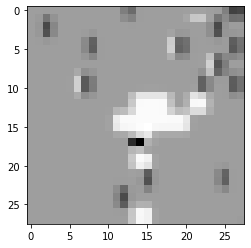

In [53]:
plt.imshow(X_test[-116].reshape(28,28), cmap='gray')
print(y_test[-116])

[1. 0. 0. 0.]


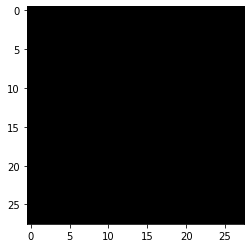

In [54]:
i = -116
plt.imshow(X[i,:,:,0], cmap="gray")
print(y[i])

In [55]:
np.max(np.argmax(model.predict(X_test[:]), axis=1))

3

# Image segmentation 

In [56]:
from pathlib import Path
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0,str(path_to_script))
import scaffan
import scaffan.image as scim
import io3d


fn = io3d.datasets.join_path("medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi", get_root=True)
anim = scim.AnnotatedImage(fn)
#
ann_ids = anim.select_annotations_by_color("#000000")
print(ann_ids)
view = anim.get_views(ann_ids, pixelsize_mm=pixelsize_mm)[0]

2019-07-11 10:07:56.378 | DEBUG    | scaffan.image:__init__:166 - Reading file C:\Users\Jirik/data/medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi
2019-07-11 10:07:56.402 | DEBUG    | scaffan.image:__init__:180 - Reading the annotation
2019-07-11 10:07:58.957 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-07-11 10:07:58.710 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'


[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


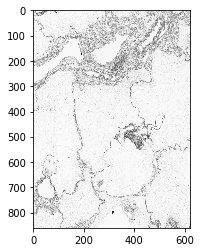

In [57]:
img = view.get_region_image(as_gray=True)
plt.imshow(img, cmap="gray")

In [59]:
seg = np.zeros_like(img, dtype=np.uint8)
for ind0 in range(0, seg.shape[0], tile_size):
    for ind1 in range(0, seg.shape[1], tile_size):
        sl1 = slice(ind0, (ind0+tile_size))
        sl2 = slice(ind1, (ind1+tile_size))
#         print(sl1, sl2)
        img0 = img[sl1,sl2]
        if img0.shape == (tile_size, tile_size):
            img0ok = img0
            pr = model.predict(img0ok.reshape(1,tile_size, tile_size, 1))
            val = np.argmax(pr)
            seg[sl1, sl2] = val
            
        

In [60]:
# img0ok.shape == (tile_size, tile_size)

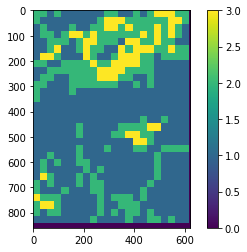

In [61]:
plt.imshow(seg)
plt.colorbar()

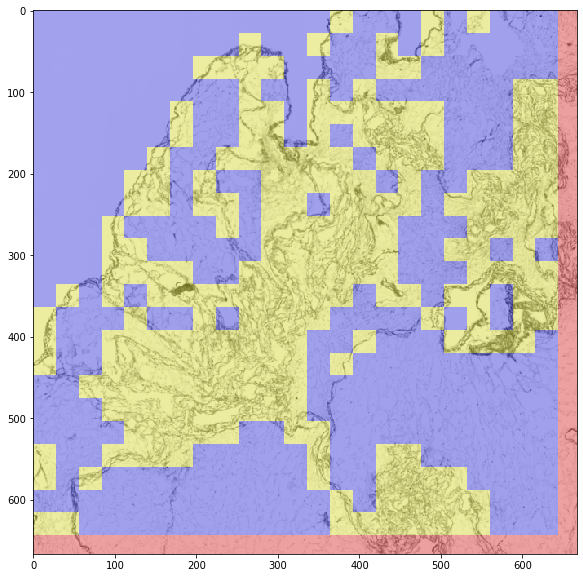

In [101]:
plt.figure(figsize(10,10))
import copy
seg2 = copy.copy(seg)
seg2[seg==2] = 3
# plt.imshow(img, cmap="gray")
# plt.contour(seg2)
# plt.imshwo(im)

image_label_overlay = skimage.color.label2rgb(seg2, image=img)
plt.imshow(image_label_overlay)

In [88]:
def make_segmentation(view, pixelsize_mm=None, as_gray=True):

    if pixelsize_mm is not None:
        img = view.to_pixelsize(pixelsize_mm).get_region_image(as_gray=as_gray)
    
    seg = np.zeros_like(img, dtype=np.uint8)
    for ind0 in range(0, seg.shape[0], tile_size):
        for ind1 in range(0, seg.shape[1], tile_size):
            sl1 = slice(ind0, (ind0+tile_size))
            sl2 = slice(ind1, (ind1+tile_size))
    #         print(sl1, sl2)
            img0 = img[sl1,sl2]
            if img0.shape == (tile_size, tile_size):
                img0ok = img0
                pr = model.predict(img0ok.reshape(1,tile_size, tile_size, 1))
                val = np.argmax(pr)
                seg[sl1, sl2] = val
    
    return seg

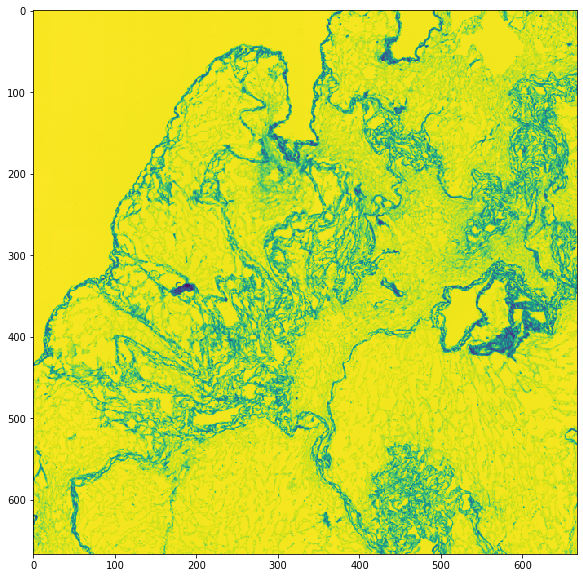

In [86]:
view_big = anim.get_view(location=[12000,10000], size_mm=[2,2], pixelsize_mm=pixelsize_mm)
img = view_big.get_region_image(as_gray=True)
plt.imshow(img)

In [91]:
img.shape

(667, 667)

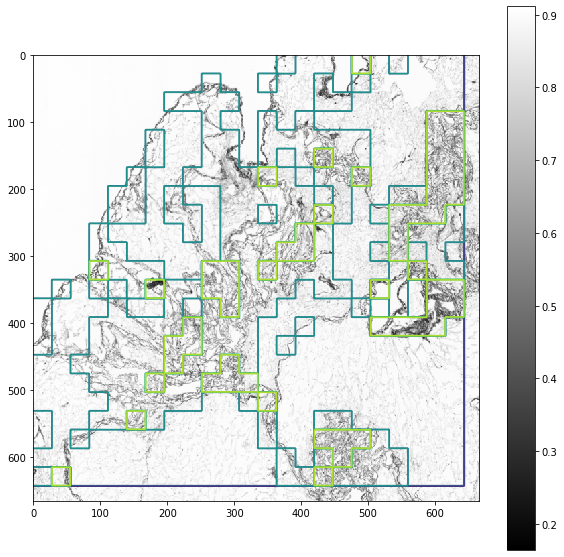

In [93]:


seg = make_segmentation(view_big, pixelsize_mm)

plt.imshow(img, cmap="gray")
plt.colorbar()
plt.contour(seg)

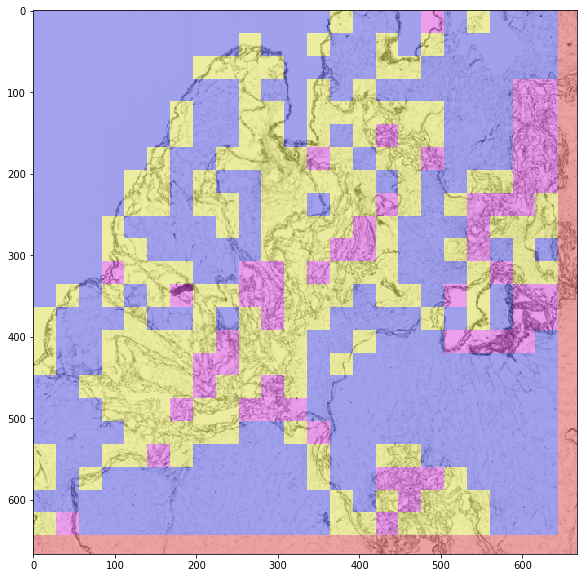

In [97]:
import skimage
image_label_overlay = skimage.color.label2rgb(seg, image=img)
plt.imshow(image_label_overlay)

In [ ]:
# Regrese

In [ ]:
from keras import optimizers

In [50]:

#create model
model = Sequential()
#add model layersfrom keras.models import Sequential
model.add(Dense(64, activation='tanh', input_shape=(8)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation="sigmoid")) # regresor mezi nula 1

In [51]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# SGD, RMSprob, Adam
#compile model
model.compile(optimizer=sgd, loss='mse')
